In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pySIVAK import pySIVAK

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import itertools
import json

In [4]:
inputdir = Path(r'../../data_results')
settingsdir = Path('Invoer')
outputdir = Path('Ontwerp laagwaterbeleid')

# Set scenario's

In [5]:
with open(settingsdir / 'settings.json') as f:
      settings = json.load(f)
        
water_plane = settings['water_plane']
dH = settings['dH']
max_pomp_inzet = settings['max_pomp_inzet']

with open(settingsdir / 'simulations.json') as f:
      simulations = json.load(f)

with open(settingsdir / 'laagwaterbeleid.json') as f:
      laagwaterbeleid = json.load(f)

# Set scenario's
# lock = 'Maasbracht'
# lock = 'Born'
lock = 'Heel'

LWB = laagwaterbeleid[lock]
SIVAK_scenarios = simulations[lock]

In [6]:
all_LWB_scenarios = [list(LWB.values())[0]] + [item for sublist in list(LWB.values())[1:] for item in sublist] 

In [7]:
# Compute max waiting time, based on scenario-name
maximum_waiting_time = {s: float(s.split(' ')[-1]) / 60 if s.startswith("R ") else 9999 for s in all_LWB_scenarios }

In [8]:
seconde_per_week = 7*24*60*60
pompkosten_per_seconde = settings['pomp_kosten'][lock]

# Read results

In [9]:
# Read instances for all runs in dict
S = {}

for scenario, name in SIVAK_scenarios.items():
    if not name in all_LWB_scenarios: continue
    print(f'{scenario} - {name}')
    
    summary_file =       inputdir / lock / 'KPI LockChambers Summary' / f'KPI_LockChambers_Summary_Avg ({scenario}).xlsx'
    ships_file =         inputdir / lock / 'Log Generated Ships' / f'Log Generated Ships ({scenario}).xlsx'
    levelings_file =     inputdir / lock / 'Log Locks Leveling' / f'Log Locks Leveling ({scenario}).xlsx'
    transit_times_file = inputdir / lock / 'Log Locks Transit Times' / f'Log Locks Transit Times ({scenario}).xlsx'

    s = pySIVAK(levelings_file, transit_times_file, ships_file, summary_file)
    
    s.correction_waitingtimes_without_new_arrivals(maximum_waiting_time=maximum_waiting_time[name])
    s.correction_leveling_without_utilization()
    s.correction_waterloss(water_plane=water_plane[lock], dH=dH[lock], downward_leveling_side=1, correct_ship_volume=True)
    
    s.name = name
    
    S[name] = s


SLH KBN 0 - Base - REF


INFO:numexpr.utils:NumExpr defaulting to 4 threads.


SLH KBN 1 - R 40 80 30 - R 40 80 30
SLH KBN 2 - R 40 80 60 - R 40 80 60
SLH KBN 3 - R 40 80 90 - R 40 80 90
SLH KBN 4 - R 60 80 90 - R 60 80 90
SLH KBN 5 - R 80 80 90 - R 80 80 90
SLH KBN 6 - R 80 80 110 - R 80 80 110


In [10]:
# Read and translate costs per shiptype
costs_per_ship_per_hour_appearance = pd.read_excel(settingsdir / 'Costs_per_shiptype.xlsx', index_col=0, header=[0,1])['Costs_per_h']
costs_per_ship_per_hour_appearance['Beladen'] = pd.read_excel(settingsdir / 'Costs_per_shiptype.xlsx', index_col=0, header=[0,1])['Costs_per_h'][['Container', 'Droge bulk', 'Natte bulk']].mean()

costs_per_ship_per_hour = costs_per_ship_per_hour_appearance[['Beladen', 'Leeg']].mean(axis=1)

costs_per_ship_per_hour['overig'] = 70
costs_per_ship_per_hour['recreatievaart'] = 0

# Correctie naar 2019:
costs_per_ship_per_hour = costs_per_ship_per_hour * 1.043

vertaaltabel_SIVAK_BIVAS = pd.read_excel(settingsdir / 'Vertaaltabel_SIVAK_BIVAS.xlsx',index_col=0)

cost_per_sivakship_per_hour = vertaaltabel_SIVAK_BIVAS.reset_index().merge(costs_per_ship_per_hour.reset_index(), left_on='BIVAS-ship', right_on='ShipTypeID').set_index('SIVAK-ship')[0]
cost_per_sivakship_per_minute = cost_per_sivakship_per_hour / 60


def compute_costs_per_hour(self):
    T = self.passage_time_per_hour_per_day_per_ship_sum()
    costs_per_ship_per_hour = T.multiply(cost_per_sivakship_per_minute, axis=1)
    costs_per_hour = costs_per_ship_per_hour.sum(axis=1).unstack().fillna(0)
    return costs_per_hour

In [11]:
# Compute some numbers per scenario: average discharge (m3/s), average passage time (minutes), costs for ships per week (eur)
Q_avg = {name: s.waterloss_per_hour_per_day().mean().mean() for name, s in S.items()}
T_avg = {name: s.transit_times['Passage time (hours)'].mean() * 60 for name, s in S.items()}
K_sum = {name: compute_costs_per_hour(s).sum().sum() for name, s in S.items()}

scenarios = pd.DataFrame({'Passage time average (min)': T_avg, 'Discharge average (m3/s)': Q_avg, 'Shipping costs (eur)': K_sum})

In [12]:
scenarios['Pompinzet (m3/s)'] = 0
scenarios['Toename kosten scheepvaart (eur) door hevelend'] = 0
scenarios['Waterbesparing door hevelend (m3/s)'] = 0
scenarios['Toename gemiddelde passeertijd (min) door hevelend'] = 0

In [13]:
# Some derived stats
scenarios['Besparing debiet scheepvaart (m3/s)'] = scenarios.loc['REF', 'Discharge average (m3/s)'] - scenarios['Discharge average (m3/s)'] 
scenarios['Toename kosten scheepvaart (eur)'] = scenarios['Shipping costs (eur)'] - scenarios['Shipping costs (eur)'][0]

### Hevelend schutten

In [14]:
toename_nivelleertijd_functie = lambda besparing_hevelend, schuttingen_hevelend:np.poly1d([  93.62172062, -229.17477846, 216.38636043, -96.43706269, 25.41039102, 0.37724583])(besparing_hevelend) * schuttingen_hevelend # min
toename_gem_wachttijd_functie = lambda schuttingen_hevelend: 0 # min

def create_scenario_hevelend(ref, schuttingen_hevelend, besparing_hevelend):
    """
    schuttingen_hevelend: [0, 1]
    besparing_hevelend: [0, 1] (1 = 100% hevelend = 50% besparing)
    """

    toename_nivelleertijd = toename_nivelleertijd_functie(besparing_hevelend, schuttingen_hevelend) # min
    toename_gem_wachttijd = toename_gem_wachttijd_functie(schuttingen_hevelend) # min
    

    # Aantal op-en-neer schuttingen --> waterbesparing per seconde
    n_schuttingen = S[ref].levelings.groupby(['Lock Chamber']).count()['Leveling ID'] / S[ref].replications / 2
    volume_zonder_hevelend = n_schuttingen * dH[lock] * pd.Series(water_plane[lock])
    volume_besparing_hevelend = 0.5*volume_zonder_hevelend * besparing_hevelend * schuttingen_hevelend
    debiet_besparing_hevelend = (volume_besparing_hevelend / seconde_per_week).sum()

    # Aantal schepen --> Toename passeerkosten
    n_ships_per_types = S[ref].transit_times.groupby('Class')['Lock'].count() / S[ref].replications

    minutes_per_shiptype = n_ships_per_types * (toename_nivelleertijd + toename_gem_wachttijd) * schuttingen_hevelend
    gemiddelde_toename = minutes_per_shiptype.sum() / n_ships_per_types.sum()

    shipping_costs_per_ship = minutes_per_shiptype.multiply(cost_per_sivakship_per_minute).dropna()
    shipping_costs_total = shipping_costs_per_ship.sum()

    name = f'{ref} H {(schuttingen_hevelend * 100):.0f} {(besparing_hevelend * 100):.0f}'
    scenario = scenarios.loc[ref].copy()
    scenario.name = name
    scenario['Toename gemiddelde passeertijd (min) door hevelend'] = gemiddelde_toename
    scenario['Toename kosten scheepvaart (eur) door hevelend'] = shipping_costs_total
    scenario['Waterbesparing door hevelend (m3/s)'] = debiet_besparing_hevelend
    
    return  scenario
    
if settings['Hevelend'][lock]:
    variaties_referenties = LWB['regimes'][:3]
    variaties_schuttingen_hevelend = [0.8]
    variaties_besparing_hevelend = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    for ref, schuttingen_hevelend, besparing_hevelend in itertools.product(variaties_referenties, variaties_schuttingen_hevelend, variaties_besparing_hevelend):
        new_scenario = create_scenario_hevelend(ref = ref, schuttingen_hevelend = schuttingen_hevelend, besparing_hevelend = besparing_hevelend)
        scenarios = scenarios.append(new_scenario)
        print(new_scenario.name)
        
    variaties_referenties = LWB['regimes'][3:]
    variaties_besparing_hevelend = [1.0]

    for ref, schuttingen_hevelend, besparing_hevelend in itertools.product(variaties_referenties, variaties_schuttingen_hevelend, variaties_besparing_hevelend):
        new_scenario = create_scenario_hevelend(ref = ref, schuttingen_hevelend = schuttingen_hevelend, besparing_hevelend = besparing_hevelend)
        scenarios = scenarios.append(new_scenario)
        print(new_scenario.name)

LWB['hevelend'] = [s for s in scenarios.index if 'H' in s]

### Create scenario's with pumps

In [15]:
def create_pomp_scenario(s, Q_pump):
    name = f'{s} P {Q_pump:.1f}'
    scenario = scenarios.loc[s].copy()
    scenario.name = name
    scenario['Pompinzet (m3/s)'] = Q_pump
    return  scenario

In [16]:
# Scenario of max pumping in ref


if max_pomp_inzet[lock]:
    new_scenario = create_pomp_scenario('REF', Q_pump=max_pomp_inzet[lock])
    scenarios = scenarios.append(new_scenario)

    print(new_scenario.name)

In [17]:
if max_pomp_inzet[lock]:
    for regime in LWB['regimes'][1:]:
        new_scenario = create_pomp_scenario(regime, Q_pump=max_pomp_inzet[lock])
        scenarios = scenarios.append(new_scenario)

        print(new_scenario.name)

In [18]:
# Create scenario's with equal pumps as ships, starting at ref_zuinig
if max_pomp_inzet[lock]:

    ref_scenarios = LWB['regimes']
    if settings['Hevelend'][lock]:
        ref_scenarios = [s + ' H 80 100' for s in ref_scenarios]
    
    besparing = - (scenarios.loc[ref_scenarios, 'Discharge average (m3/s)'] - scenarios.loc[LWB['ref_zuinig'], 'Discharge average (m3/s)'])
    besparing = besparing[besparing > 0.001]
    besparing.loc[besparing > max_pomp_inzet[lock]] = max_pomp_inzet[lock]

    for s, Q in besparing.items():
        new_scenario = create_pomp_scenario(s, Q_pump=Q)
        scenarios = scenarios.append(new_scenario)

        print(new_scenario.name)

    Q_extra = max_pomp_inzet[lock]
    new_scenario = create_pomp_scenario(s, Q_pump=Q_extra)
    scenarios = scenarios.append(new_scenario)

    print(new_scenario.name)

In [19]:
# Create scenario's with equal costs for pumps as ships, starting at R 40 80 30
if max_pomp_inzet[lock]:
    
    ref_scenarios = LWB['regimes']
    if settings['Hevelend'][lock]:
        ref_scenarios = [s + ' H 80 100' for s in ref_scenarios]
    
    besparing = scenarios.loc[ref_scenarios, 'Toename kosten scheepvaart (eur)']  - scenarios.loc[LWB['ref_zuinig'], 'Toename kosten scheepvaart (eur)']
    besparing = besparing / (seconde_per_week * pompkosten_per_seconde)
    besparing = besparing[besparing > 0.001]
    besparing.loc[besparing > max_pomp_inzet[lock]] = max_pomp_inzet[lock]


    for s, Q in besparing.items():
        new_scenario = create_pomp_scenario(s, Q_pump=Q)
        scenarios = scenarios.append(new_scenario)

        print(new_scenario.name)
        

    Q_extra = max_pomp_inzet[lock]
    new_scenario = create_pomp_scenario(s, Q_pump=Q_extra)
    scenarios = scenarios.append(new_scenario)

    print(new_scenario.name)

In [20]:
# Max pompen bij zuinig 
if max_pomp_inzet[lock]:
    new_scenario = create_pomp_scenario(LWB['ref_zuinig'], Q_pump=max_pomp_inzet[lock])
    scenarios = scenarios.append(new_scenario)

    print(new_scenario.name)
    
    if 'ref_zuinig2' in LWB:
        new_scenario = create_pomp_scenario(LWB['ref_zuinig2'], Q_pump=max_pomp_inzet[lock])
        scenarios = scenarios.append(new_scenario)

        print(new_scenario.name)

In [21]:
# Pompen na hevelend
if max_pomp_inzet[lock]:
    scenarios_hevelend_waarbij_ook_pompen = [s for s in scenarios.index if 'H 100 100' in s]
    for s in scenarios_hevelend_waarbij_ook_pompen:
        new_scenario = create_pomp_scenario(s, Q_pump=max_pomp_inzet[lock])
        scenarios = scenarios.append(new_scenario)

### Stats

In [22]:
def derived_stats(scenarios):
    # Some more derived statistics
    scenarios = scenarios.copy()
    
    scenarios['Totale gemiddelde passeertijd (min)'] = scenarios['Passage time average (min)'] + scenarios['Toename gemiddelde passeertijd (min) door hevelend']

    scenarios['Totale toename kosten scheepvaart (eur)'] = scenarios['Toename kosten scheepvaart (eur)'] + scenarios['Toename kosten scheepvaart (eur) door hevelend']
    scenarios['Totale toename kosten scheepvaart (eur) per dag'] = scenarios['Totale toename kosten scheepvaart (eur)'] / 7

    scenarios['Pompkosten (eur)'] = scenarios['Pompinzet (m3/s)'] * seconde_per_week * pompkosten_per_seconde
    scenarios['Pompkosten (eur) per dag'] = scenarios['Pompkosten (eur)'] / 7

    scenarios['Totale debiet (m3/s)'] = scenarios['Discharge average (m3/s)'] - scenarios['Pompinzet (m3/s)'] - scenarios['Waterbesparing door hevelend (m3/s)']
    scenarios['Totale waterbesparing (m3/s)'] = scenarios['Totale debiet (m3/s)'][0] - scenarios['Totale debiet (m3/s)']

    scenarios['Totale kosten (eur)'] = scenarios['Totale toename kosten scheepvaart (eur)'] + scenarios['Pompkosten (eur)']
    scenarios['Totale kosten (eur) per dag'] = scenarios['Totale kosten (eur)'] / 7
    scenarios['Totale kosten (eur) per uur'] = scenarios['Totale kosten (eur)'] / 7 / 24
    
    scenarios = scenarios.drop_duplicates()
    return scenarios
    
scenarios = derived_stats(scenarios)

In [42]:
# Extrapolatie
def add_extrapolated_scen(scenarios, idxmin, penalty):
    
    scen_new = idxmin + ' extrapolatie'
    
    scenarios.loc[scen_new] = None
    
    scenarios.loc[scen_new, 'Totale toename kosten scheepvaart (eur) per dag'] = penalty
    scenarios.loc[scen_new, 'Totale debiet (m3/s)'] = 0
    scenarios.loc[scen_new, 'Totale waterbesparing (m3/s)'] = scenarios['Totale debiet (m3/s)'][0] - scenarios.loc[scen_new, 'Totale debiet (m3/s)']
    scenarios.loc[scen_new, 'Totale kosten (eur) per dag'] = scenarios.loc[scen_new, 'Totale toename kosten scheepvaart (eur) per dag']
    scenarios.loc[scen_new, 'Waterbesparing door hevelend (m3/s)'] = scenarios.loc[idxmin, 'Waterbesparing door hevelend (m3/s)']
    scenarios.loc[scen_new, 'Pompkosten (eur)'] = 0
    scenarios.loc[scen_new, 'Besparing debiet scheepvaart (m3/s)'] = scenarios['Totale debiet (m3/s)'][0]
    return scenarios

In [24]:
if scenarios['Totale debiet (m3/s)'].min() > 0:
    idxmin = scenarios['Totale debiet (m3/s)'].idxmin()
    scenarios = add_extrapolated_scen(scenarios, idxmin, 10000)

### Plots

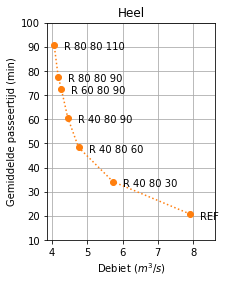

In [25]:
# Debiet -- Passeertijd
f, ax = plt.subplots(figsize=(3,4))

plot_scenarios = LWB['unused']
scenarios.loc[plot_scenarios].plot(x='Totale debiet (m3/s)', y='Passage time average (min)', zorder=3, marker='o', ls='none', legend=False, ax=ax, fillstyle='none', color='C1')

plot_scenarios = LWB['regimes']
scenarios.loc[plot_scenarios].plot(x='Totale debiet (m3/s)', y='Passage time average (min)', zorder=3, marker='o', ls=':', legend=False, ax=ax, color='C1')



for i, r in scenarios.loc[plot_scenarios + LWB['unused']].iterrows():
    plt.annotate(i, xy=(r['Totale debiet (m3/s)'], r['Passage time average (min)']), xytext=(10, -5), textcoords='offset points')


    
# plt.xlim(-4, 20)
plt.xlim(right=(plt.gca().get_xlim()[1] + 0.5))
plt.ylim(10, 100)
plt.xlabel('Debiet ($m^3/s$)')
plt.ylabel('Gemiddelde passeertijd (min)')
plt.grid(c='#AAA')
plt.title(lock)

plt.savefig(    outputdir / f'{lock}_Debiet_passeertijd.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Debiet_passeertijd.svg', bbox_inches='tight')


In [26]:

if len(LWB['hevelend']):
        # Debiet -- Passeertijd
    f, ax = plt.subplots(figsize=(8,4))

    plot_scenarios = LWB['unused']
    scenarios.loc[plot_scenarios].plot(x='Totale debiet (m3/s)', y='Passage time average (min)', zorder=3, marker='o', ls='none', legend=False, ax=ax, fillstyle='none', color='C1')

    plot_scenarios = LWB['regimes']
    scenarios.loc[plot_scenarios].plot(x='Totale debiet (m3/s)', y='Passage time average (min)', zorder=3, marker='o', ls=':', legend=False, ax=ax, color='C1')



    for i, r in scenarios.loc[plot_scenarios + LWB['unused']].iterrows():
        plt.annotate(i, xy=(r['Totale debiet (m3/s)'], r['Passage time average (min)']), xytext=(10, -5), textcoords='offset points')


    scenarios.loc[LWB['hevelend']].plot(x='Totale debiet (m3/s)', y='Totale gemiddelde passeertijd (min)', zorder=3, marker='v', ls='none', legend=False, ax=ax, color='C2')

    for i, r in scenarios.loc[LWB['hevelend']].iloc[[0, 5, 11, 17,  -1]].iterrows():
        plt.annotate(i, xy=(r['Totale debiet (m3/s)'], r['Totale gemiddelde passeertijd (min)']), xytext=(0, -5), textcoords='offset points', ha='right', va='top')


    # plt.xlim(-4, 20)
    plt.xlim(right=(plt.gca().get_xlim()[1] + 0.5))
    plt.ylim(10, 100)
    plt.xlabel('Debiet ($m^3/s$)')
    plt.ylabel('Gemiddelde passeertijd (min)')
    plt.grid(c='#AAA')
    plt.title(lock)

    plt.xlim(0, 17)

    plt.savefig(    outputdir / f'{lock}_Debiet_passeertijd_incl_hevelend.png', bbox_inches='tight', dpi=150)
    plt.savefig(    outputdir / f'{lock}_Debiet_passeertijd_incl_hevelend.svg', bbox_inches='tight')


In [27]:
# # Debiet -- Passeerkosten
# f, ax  = plt.subplots()

# plot_scenarios = [LWB['ref']] + LWB['regimes']
# scenarios.loc[plot_scenarios].plot(x='Discharge average (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', legend=False, ax=ax)

# for i, r in scenarios.loc[plot_scenarios].iterrows():
#     plt.annotate(i, xy=(r['Discharge average (m3/s)'], r['Totale kosten (eur) per dag']), xytext=(10, 0), textcoords='offset points')


# scenarios.loc[LWB['hevelend']].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls='none', marker='o', legend=False, ax=ax, c='C2')

# # for i, r in scenarios.loc[LWB['hevelend']].iterrows():
# #     plt.annotate(i, xy=(r['Totale debiet (m3/s)'], r['Totale kosten (eur) per dag']), xytext=(-10, 0), textcoords='offset points', ha='right', va='top')



# plt.xlim(0, 20)
# # plt.ylim(0, 7000)
# plt.xlabel('Debiet ($m^3/s$)')
# plt.ylabel('Passeerkosten per dag (eur)')
# plt.grid(c='#AAA')
# plt.title(lock)

# # plt.yticks(locs, map(lambda x: "%.1f" % x, plt.gca().get_yticks()/1e3))
# plt.savefig(    outputdir / f'{lock}_Debiet_passeerkosten.png', bbox_inches='tight', dpi=150)
# plt.savefig(    outputdir / f'{lock}_Debiet_passeerkosten.svg', bbox_inches='tight')
# # plotdata.to_csv(outputdir / f'{lock}_Debiet_passeertijd.csv')

In [28]:

def addSecond_x_axes(ax1_ticks, ax2_ticks_labels, ax2_color='#888', ax2_label=None, ax1=None, position=40):
    '''
    Add a second xlabel below the current
    
    ax1_ticks: Locations on current xaxis where markers should be placed
    ax2_ticks_labels: Labels to put at these positions
    
    ax2_color: Color of all ax2 objects
    ax2_label: xlabel
    ax1: axes to apply function on. By default uses current axes
    
    return: ax2 handle
    '''
    
    if not ax1:
        ax1=plt.gca()
        
    assert all(ax1_ticks >= ax1.get_xlim()[0]) and all(ax1_ticks <= ax1.get_xlim()[1]), 'ax1_ticks larger than xlim. Ticks: {ticks}; Limits: {limits}'.format(ticks=ax1_ticks, limits=ax1.get_xlim())
   
    ax2 = ax1.twiny()

    ax2.xaxis.tick_bottom()
    ax2.xaxis.set_label_position('bottom') 
    ax2.spines['bottom'].set_position(('outward', position))
    ax2.spines['bottom'].set_color(ax2_color)
    ax2.tick_params(axis='x', colors=ax2_color)

    ax2.set_xlim(ax1.get_xlim())

    ax2.set_xticks(ax1_ticks, )
    ax2.set_xticklabels(ax2_ticks_labels)
    ax2.set_xlabel(ax2_label, color=ax2_color)
    return ax2


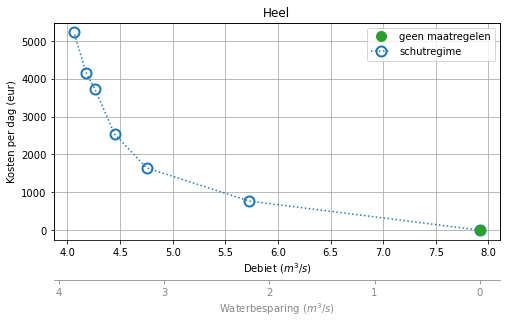

In [29]:
# Debiet -- Passeerkosten
f, ax  = plt.subplots(figsize=(8,4))

# scenarios.loc[[LWB['ref']]].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls='none', marker='s', legend=False, ax=ax, markersize=10, c='C4', label='geen maatregelen', zorder=6)
scenarios.loc[[LWB['ref']]].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls='none', marker='o', legend=False, ax=ax, markersize=10, c='C2', label='geen maatregelen', zorder=6)

scenarios_with_regime = LWB['regimes']
scenarios.loc[scenarios_with_regime].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', legend=False, ax=ax, c='C0', markersize=10, label='schutregime', fillstyle='none', zorder=5, markeredgewidth=2)

scenarios_with_hevelend = [LWB['ref']] + [s for s in scenarios.index if ('REF H ' in s) & ('P' not in s)]
if len(scenarios_with_hevelend) > 1:
    scenarios.loc[scenarios_with_hevelend].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', legend=False, ax=ax, markersize=8, label='hevelend', c='C1')

scenarios_with_pumps = [LWB['ref']] + [s for s in scenarios.index if 'REF P ' in s]
if len(scenarios_with_pumps) > 1:
    scenarios.loc[scenarios_with_pumps].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', legend=False, ax=ax, markersize=2, label='pompen', c='k')

    
# plt.xlim(0, 16)
plt.xlabel('Debiet ($m^3/s$)')
plt.ylabel('Kosten per dag (eur)')
plt.grid(c='#AAA')
plt.title(lock)
plt.legend()
# plt.ylim(0)

ref = scenarios.loc[[LWB['ref']]]
x2_ticks = np.arange(0, scenarios['Totale waterbesparing (m3/s)'].max(), 1)
x1_ticks = ref['Totale debiet (m3/s)'][0] - x2_ticks

ii = x1_ticks >= plt.gca().get_xlim()[0]
x2_ticks = x2_ticks[ii]
x1_ticks = x1_ticks[ii]

x2_labels = [f'{s:.0f}' for s in x2_ticks]
addSecond_x_axes(x1_ticks, x2_labels, ax2_label='Waterbesparing ($m^3/s$)')

plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_scenarios_geen_combinaties.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_scenarios_geen_combinaties.svg', bbox_inches='tight')
# plotdata.to_csv(outputdir / f'{lock}_Debiet_passeertijd.csv')

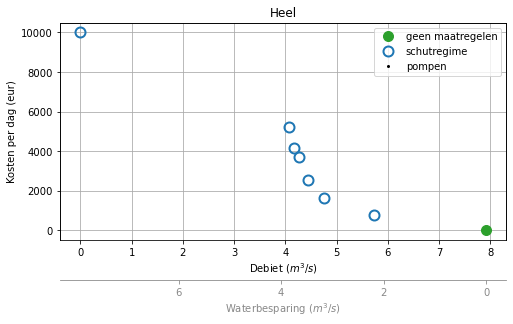

In [30]:
# Debiet -- Passeerkosten
f, ax  = plt.subplots(figsize=(8,4))

scenarios.loc[[LWB['ref']]].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls='none', marker='o', legend=False, ax=ax, markersize=10, c='C2', label='geen maatregelen', zorder=6)

scenarios_with_regime = [s for s in scenarios.index if 'R ' in s]
scenarios.loc[scenarios_with_regime].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls='none', marker='o', legend=False, ax=ax, c='C0', markersize=10, label='schutregime', fillstyle='none', zorder=5, markeredgewidth=2)

scenarios_with_hevelend = [s for s in scenarios.index if 'H ' in s]
if len(scenarios_with_hevelend) > 1:
    scenarios.loc[scenarios_with_hevelend].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls='none', marker='o', legend=False, ax=ax, markersize=8, label='hevelend', c='C1')

scenarios_with_pumps = [s for s in scenarios.index if 'P ' in s]
scenarios.loc[scenarios_with_pumps].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls='none', marker='o', legend=False, ax=ax, markersize=2, label='pompen', c='k')

    
# plt.xlim(0, 16)
# plt.ylim(0)
plt.xlabel('Debiet ($m^3/s$)')
plt.ylabel('Kosten per dag (eur)')
plt.grid(c='#AAA')
plt.title(lock)
plt.legend()


ref = scenarios.loc[[LWB['ref']]]
x2_ticks = np.arange(0, scenarios['Totale waterbesparing (m3/s)'].max(), 2)
x1_ticks = ref['Totale debiet (m3/s)'][0] - x2_ticks
x2_labels = [f'{s:.0f}' for s in x2_ticks]
addSecond_x_axes(x1_ticks, x2_labels, ax2_label='Waterbesparing ($m^3/s$)')

plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_scenarios_alle.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_scenarios_alle.svg', bbox_inches='tight')
# plotdata.to_csv(outputdir / f'{lock}_Debiet_passeertijd.csv')

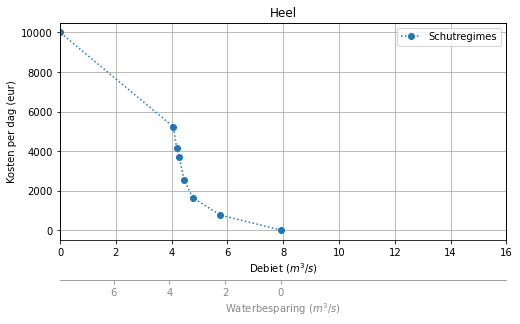

In [31]:
# plotdata.plot.scatter(x='Discharge average (m3/s)', y='Shipping costs (eur)', zorder=3)
# plotdata.iloc[:-1].set_index('Totale debiet (m3/s)')['Totale kosten (eur)'].plot(ls=':', marker='o')
# plotdata.iloc[[0, -1], :].set_index('Totale debiet (m3/s)')['Totale kosten (eur)'].plot(ls=':', marker='o')
f, ax = plt.subplots(figsize=(8,4))

for LWB_name, LWB_ids in LWB['exports'].items():
    scenarios.loc[LWB_ids].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', ax=ax, label=LWB_name)

    
plt.xlim(0, 16)
# plt.ylim(0, 10e3)
plt.xlabel('Debiet ($m^3/s$)')
plt.ylabel('Kosten per dag (eur)')
plt.grid(c='#AAA')
plt.title(lock)


ref = scenarios.loc[[LWB['ref']]]
x2_ticks = np.arange(0, ref['Totale debiet (m3/s)'][0], 2)
x1_ticks = ref['Totale debiet (m3/s)'][0] - x2_ticks
x2_labels = [f'{s:.0f}' for s in x2_ticks]
addSecond_x_axes(x1_ticks, x2_labels, ax2_label='Waterbesparing ($m^3/s$)')

plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_scenarios.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_scenarios.svg', bbox_inches='tight')
scenarios.to_csv(outputdir / f'{lock}_Laagwaterbeleid_scenarios.csv')
# plotdata.to_csv(outputdir / f'{lock}_Debiet_passeertijd.csv')

In [32]:
def plot_lwb(refline=LWB['ref_zuinig']):
    f, ax = plt.subplots(ncols=2, figsize=(10,4))
    plt.subplots_adjust(wspace=0.3)

    plt.sca(ax[0])
    if laagwaterbeleid['Waterbesparing door hevelend (m3/s)'].max() > 0:
        laagwaterbeleid.plot(kind='area', y=['Waterbesparing door hevelend (m3/s)', 'Besparing debiet scheepvaart (m3/s)', 'Pompinzet (m3/s)', ], ax=ax[0], label=['Hevelen','Schutregimes', 'Pompinzet', ], lw=0, color=['C2', 'C0', 'C1'])
    else:
        laagwaterbeleid.plot(kind='area', y=['Besparing debiet scheepvaart (m3/s)', 'Pompinzet (m3/s)', ], ax=ax[0], label=['Schutregimes', 'Pompinzet',], lw=0)
    
    plt.axhline(scenarios.loc[refline, 'Totale waterbesparing (m3/s)'], ls=':', c='k')
    
    plt.xlim(0, )
    if lock == 'Born':
        plt.ylim(0, 14)
    else:
        plt.ylim(0, 17)
    plt.grid(alpha=0.3)
    plt.xlabel('Beschikbare afvoer ($m^3/s$)')
    plt.ylabel('Maatregelen voor waterbesparing ($m^3/s$)')
    # plt.legend()

    plt.sca(ax[1])
    laagwaterbeleid.plot(kind='area', y=['Totale toename kosten scheepvaart (eur) per dag', 'Pompkosten (eur) per dag'], ax=ax[1], label=['Kosten voor scheepvaart', 'Pompkosten'], lw=0)
    
    plt.axhline(scenarios.loc[refline, 'Totale kosten (eur) per dag'], ls=':', c='k')

    plt.xlim(0, )
    plt.ylim(0, 10000)
    plt.grid(alpha=0.3)
    plt.xlabel('Beschikbare afvoer ($m^3/s$)')
    plt.ylabel('Kosten per dag (eur)')

    plt.suptitle(f'{lock}: {LWB_name}')

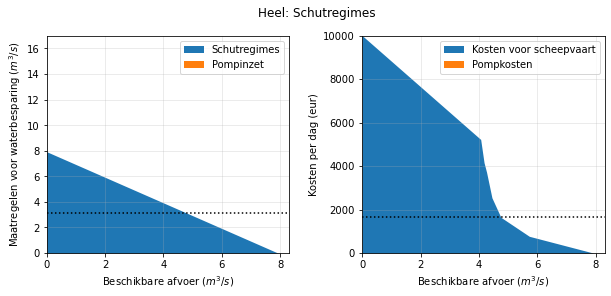

In [33]:
for LWB_name, LWB_ids in LWB['exports'].items():

    laagwaterbeleid = scenarios.loc[LWB_ids]
    laagwaterbeleid = laagwaterbeleid.reset_index().set_index('Totale debiet (m3/s)').drop_duplicates()
    laagwaterbeleid.to_csv(outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.csv')
    
    plot_lwb()
    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.png', bbox_inches='tight', dpi=150)
    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.svg', bbox_inches='tight')
    plt.show()

# Maatregelen

In [34]:
if lock == 'Maasbracht':
    s_list = [s for s in LWB['exports']['Gelijke waterbesparing'] if 'REF' in s] + ['R 40 80 30 H 80 100']

    rest_debiet = scenarios.loc[s_list[-1]]['Totale debiet (m3/s)']

    new_scenario = create_pomp_scenario(s=s_list[-1], Q_pump=rest_debiet)
    scenarios = scenarios.append(new_scenario)

    scenarios = derived_stats(scenarios)

    s_list = s_list + [new_scenario.name]

    LWB_name = 'Maatregel hogere pompcapaciteit'

    laagwaterbeleid = scenarios.loc[s_list]
    laagwaterbeleid = laagwaterbeleid.reset_index().set_index('Totale debiet (m3/s)').drop_duplicates()
    laagwaterbeleid.to_csv(outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.csv')


    plot_lwb(refline='REF')

    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.png', bbox_inches='tight', dpi=150)
    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.svg', bbox_inches='tight')

In [35]:
if lock == 'Born':
    s_list = LWB['exports']["Zuinig schutregime dan pompen"][:-1]

    rest_debiet = scenarios.loc[s_list[-1]]['Totale debiet (m3/s)']

    new_scenario = create_pomp_scenario(s=s_list[-1], Q_pump=rest_debiet)
    scenarios = scenarios.append(new_scenario)

    scenarios = derived_stats(scenarios)

    s_list = s_list + [new_scenario.name]

    LWB_name = 'Maatregel hogere pompcapaciteit'

    laagwaterbeleid = scenarios.loc[s_list]
    laagwaterbeleid = laagwaterbeleid.reset_index().set_index('Totale debiet (m3/s)').drop_duplicates()
    laagwaterbeleid.to_csv(outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.csv')


    plot_lwb(refline='REF')

    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.png', bbox_inches='tight', dpi=150)
    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.svg', bbox_inches='tight')

In [36]:
if lock == 'Maasbracht':
    s_list = LWB['exports']['Gelijke kosten']
    
    for p in [0.7, 0.8, 0.9]:
        LWB_name = f'Maatregel pompefficientie {p:.0%}'

        laagwaterbeleid = scenarios.loc[s_list]

        laagwaterbeleid['Pompkosten (eur) per dag'] = laagwaterbeleid['Pompkosten (eur) per dag'] * 0.4982/p

        laagwaterbeleid = laagwaterbeleid.reset_index().set_index('Totale debiet (m3/s)').drop_duplicates()
        laagwaterbeleid.to_csv(outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.csv')


        plot_lwb(refline='REF')

        plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.png', bbox_inches='tight', dpi=150)
        plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.svg', bbox_inches='tight')

In [37]:
if lock == 'Born':
    s_list = LWB['exports']['Gelijke kosten']
    
    for p in [0.7, 0.8, 0.9]:
        LWB_name = f'Maatregel pompefficientie {p:.0%}'

        laagwaterbeleid = scenarios.loc[s_list]

        laagwaterbeleid['Pompkosten (eur) per dag'] = laagwaterbeleid['Pompkosten (eur) per dag'] * 0.5567175/p

        laagwaterbeleid = laagwaterbeleid.reset_index().set_index('Totale debiet (m3/s)').drop_duplicates()
        laagwaterbeleid.to_csv(outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.csv')


        plot_lwb(refline=LWB['ref_zuinig'])

        plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.png', bbox_inches='tight', dpi=150)
        plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.svg', bbox_inches='tight')

In [39]:
new_scenario.name

'R 80 80 110 H 100 100'

REF H 100 80
REF H 100 100
R 40 80 30 H 100 80
R 40 80 30 H 100 100
R 40 80 60 H 100 80
R 40 80 60 H 100 100
R 40 80 90 H 100 80
R 40 80 90 H 100 100
R 60 80 90 H 100 80
R 60 80 90 H 100 100
R 80 80 90 H 100 80
R 80 80 90 H 100 100
R 80 80 110 H 100 80
R 80 80 110 H 100 100


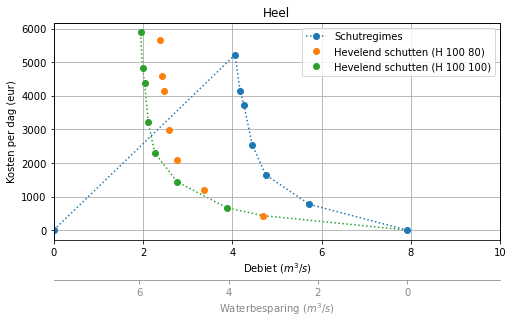

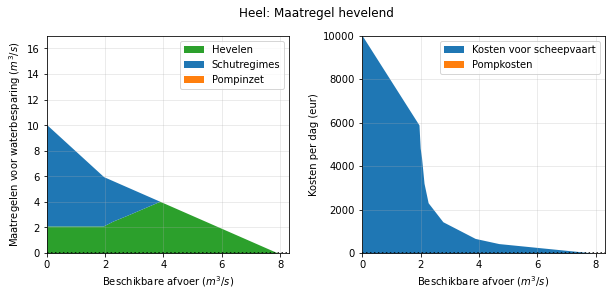

In [43]:
if lock == 'Heel':
    variaties_referenties = LWB['regimes']
    variaties_schuttingen_hevelend = [1.0]
    variaties_besparing_hevelend = [0.8, 1.0]

    for ref, schuttingen_hevelend, besparing_hevelend in itertools.product(variaties_referenties, variaties_schuttingen_hevelend, variaties_besparing_hevelend):
        new_scenario = create_scenario_hevelend(ref = ref, schuttingen_hevelend = schuttingen_hevelend, besparing_hevelend = besparing_hevelend)
        scenarios = scenarios.append(new_scenario)
        print(new_scenario.name)
    
    scenarios = scenarios.drop_duplicates()
    
    scenarios = derived_stats(scenarios)

    f, ax = plt.subplots(figsize=(8,4))

    s_list = [s for s in scenarios.index if ('R' in s) & ('H ' not in s)]
    scenarios.loc[s_list].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', ax=ax, label='Schutregimes')

    s_list = [s for s in scenarios.index if ('H 100 80' in s)]
    scenarios.loc[s_list].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls='none', marker='o', ax=ax, label='Hevelend schutten (H 100 80)')

    s_list = [s for s in scenarios.index if ('H 100 100' in s)]
    scenarios.loc[s_list].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls='none', marker='o', ax=ax, label='Hevelend schutten (H 100 100)')

    s_list = ['REF', 'REF H 100 80'] + s_list
    scenarios.loc[s_list].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', c='C2', ax=ax, label='', legend=False, zorder=-3)


    plt.xlim(0, 10)
    # plt.ylim(0, 10e3)
    plt.xlabel('Debiet ($m^3/s$)')
    plt.ylabel('Kosten per dag (eur)')
    plt.grid(c='#AAA')
    plt.title(lock)


    ref = scenarios.loc[[LWB['ref']]]
    x2_ticks = np.arange(0, ref['Totale debiet (m3/s)'][0], 2)
    x1_ticks = ref['Totale debiet (m3/s)'][0] - x2_ticks
    x2_labels = [f'{s:.0f}' for s in x2_ticks]
    addSecond_x_axes(x1_ticks, x2_labels, ax2_label='Waterbesparing ($m^3/s$)')

    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_maatregel_hevelend.png', bbox_inches='tight', dpi=150)
    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_maatregel_hevelend.svg', bbox_inches='tight')
    
    scenarios = add_extrapolated_scen(scenarios, new_scenario.name, 10000)
    
    LWB_name = 'Maatregel hevelend'
    
    s_list = s_list + ['R 80 80 110 H 100 100 extrapolatie']
    
    laagwaterbeleid = scenarios.loc[s_list]
    laagwaterbeleid = laagwaterbeleid.reset_index().set_index('Totale debiet (m3/s)').drop_duplicates()
    laagwaterbeleid.to_csv(outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.csv')

    plot_lwb(refline='REF')
    
    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.png', bbox_inches='tight', dpi=150)
    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.svg', bbox_inches='tight')

In [ ]:
if lock == 'Born':
    
    variaties_referenties = LWB['regimes']
    variaties_schuttingen_hevelend = [1.0]
    variaties_besparing_hevelend = [1.0]

    for ref, schuttingen_hevelend, besparing_hevelend in itertools.product(variaties_referenties, variaties_schuttingen_hevelend, variaties_besparing_hevelend):
        new_scenario = create_scenario_hevelend(ref = ref, schuttingen_hevelend = schuttingen_hevelend, besparing_hevelend = besparing_hevelend)
        scenarios = scenarios.append(new_scenario)
        print(new_scenario.name)
        

    ref_scenarios = LWB['regimes']
    ref_scenarios = [s + ' H 100 100' for s in ref_scenarios]
    
    besparing = scenarios.loc[ref_scenarios, 'Toename kosten scheepvaart (eur)']  - scenarios.loc[LWB['ref_zuinig'], 'Toename kosten scheepvaart (eur)']
    besparing = besparing / (seconde_per_week * pompkosten_per_seconde)
    besparing = besparing[besparing > 0.001].drop_duplicates()
    besparing.loc[besparing > max_pomp_inzet[lock]] = max_pomp_inzet[lock]


    for s, Q in besparing.items():
        new_scenario = create_pomp_scenario(s, Q_pump=Q)
        scenarios = scenarios.append(new_scenario)

        print(new_scenario.name)
        

    Q_extra = max_pomp_inzet[lock]
    new_scenario = create_pomp_scenario(s, Q_pump=Q_extra)
    scenarios = scenarios.append(new_scenario)

    print(new_scenario.name)

    scenarios = derived_stats(scenarios)
    scenarios = scenarios.drop_duplicates()

    f, ax = plt.subplots(figsize=(8,4))
    
    LWB_name = 'Gelijke kosten'
    scenarios.loc[LWB['exports'][LWB_name]].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', ax=ax, label=LWB_name)

    s_list = ['REF', 'REF H 100 100', 'R 40 80 30 H 100 100'] + [s for s in scenarios.index if ('H 100 100 P' in s)]
    scenarios.loc[s_list].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', ax=ax, label='Hevelend schutten')



    plt.xlim(0, 14)
    plt.ylim(-200, 7e3)
    plt.xlabel('Debiet ($m^3/s$)')
    plt.ylabel('Kosten per dag (eur)')
    plt.grid(c='#AAA')
    plt.title(lock)


    ref = scenarios.loc[[LWB['ref']]]
    x2_ticks = np.arange(0, ref['Totale debiet (m3/s)'][0], 2)
    x1_ticks = ref['Totale debiet (m3/s)'][0] - x2_ticks
    x2_labels = [f'{s:.0f}' for s in x2_ticks]
    addSecond_x_axes(x1_ticks, x2_labels, ax2_label='Waterbesparing ($m^3/s$)')

    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_maatregel_hevelend.png', bbox_inches='tight', dpi=150)
    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_maatregel_hevelend.svg', bbox_inches='tight')
    
    LWB_name = 'Maatregel hevelend'

    laagwaterbeleid = scenarios.loc[s_list]
    laagwaterbeleid = laagwaterbeleid.reset_index().set_index('Totale debiet (m3/s)').drop_duplicates()
    laagwaterbeleid.to_csv(outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.csv')
    
    plot_lwb(refline='R 40 80 30 H 100 100')
    
    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.png', bbox_inches='tight', dpi=150)
    plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_{LWB_name}.svg', bbox_inches='tight')